In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# -------------------------------------------------------------------
# Domain bounds for each coordinate
# -------------------------------------------------------------------
# We consider a 3D domain in (x, y, t):
#   - x-direction: from -50 to 50
#   - y-direction: from  0  to 20
#   - time t:      from  0  to 10
# These bounds will be used to sample collocation points and BC/IC points.
x_min, x_max = -50, 50
y_min, y_max = 0, 20
t_min, t_max = 0, 10

# -------------------------------------------------------------------
# Number of sampled points for each set
# -------------------------------------------------------------------
# N_colloc : number of collocation points in the interior of the domain
# N_ic     : number of points used to enforce the initial condition at t = 0
# N_bc     : number of points used to enforce boundary conditions on x- and y-boundaries
N_colloc = 20000
N_ic = 2000
N_bc = 2000


def generate_collocation_points(N):
    """
    Sample N collocation points (x, y, t) in the interior of the 3D domain.

    These points are used to enforce the PDE residual:
        F(x, y, t, u, ∂u/∂x, ∂u/∂y, ∂u/∂t, ...) = 0
    via a Monte Carlo approximation of the integral over the domain.
    """
    # Sample x uniformly in [x_min, x_max]
    x = np.random.uniform(x_min, x_max, N)
    # Sample y uniformly in [y_min, y_max]
    y = np.random.uniform(y_min, y_max, N)
    # Sample t uniformly in [t_min, t_max]
    t = np.random.uniform(t_min, t_max, N)

    # Stack x, y, t into an array of shape (N, 3),
    # where each row is a point [x_i, y_i, t_i].
    pts = np.stack([x, y, t], axis=1)

    # Convert to a float32 PyTorch tensor and move to the chosen device (CPU/GPU).
    return torch.tensor(pts, dtype=torch.float32).to(device)


def generate_initial_points(N):
    """
    Sample N points on the initial-time surface t = 0 and
    return both the coordinates X_ic and the corresponding target values u_ic.

    Here the initial condition is defined as a top-hat / indicator profile in x:
        u(x, y, t=0) = 1  if |x| <= 5
                        0  otherwise

    Note: u depends only on x (not on y) in this initialization.
    """
    # Sample x uniformly in [x_min, x_max] at t = 0
    x = np.random.uniform(x_min, x_max, N)
    # Sample y uniformly in [y_min, y_max] at t = 0
    y = np.random.uniform(y_min, y_max, N)
    # For initial condition points, time is fixed at t = 0
    # We create an array of zeros with the same shape as x.
    t = np.zeros_like(x)

    # Define the initial condition values u(x, y, 0).
    # (np.abs(x) <= 5) gives a boolean array:
    #   True  where |x| <= 5
    #   False where |x|  > 5
    # astype(np.float32) converts:
    #   True  -> 1.0
    #   False -> 0.0
    u = (np.abs(x) <= 5).astype(np.float32)

    # Stack (x, y, t) into shape (N, 3), then convert to a tensor on device.
    X_ic = torch.tensor(np.stack([x, y, t], axis=1), dtype=torch.float32).to(device)

    # Convert u to a tensor of shape (N, 1) on device so it matches NN output shape.
    # u has shape (N,), so u[:, None] makes it (N, 1).
    u_ic = torch.tensor(u[:, None], dtype=torch.float32).to(device)

    # X_ic : coordinates of initial condition points on t = 0 plane
    # u_ic : corresponding scalar initial condition values
    return X_ic, u_ic


def generate_neumann_bc_points(N):
    """
    Sample N points on the x-boundaries (left and right walls) for Neumann BCs.

    This function generates points on:
        x = x_min  and  x = x_max
    with y and t spanning the full ranges [y_min, y_max], [t_min, t_max].

    These points can be used to enforce Neumann-type boundary conditions, e.g.:
        ∂u/∂x = 0  at x = x_min, x_max
    by sampling points on those boundary surfaces and penalizing the normal derivative.
    """
    # Choose N x-coordinates, each either x_min or x_max, with equal probability.
    # This places all points on the two vertical boundaries in x.
    x = np.random.choice([x_min, x_max], N)

    # Sample y along the boundary line uniformly in [y_min, y_max].
    y = np.random.uniform(y_min, y_max, N)

    # Sample t along the boundary for the entire time interval [t_min, t_max].
    t = np.random.uniform(t_min, t_max, N)

    # Stack into an array of shape (N, 3) and convert to tensor.
    pts = np.stack([x, y, t], axis=1)
    return torch.tensor(pts, dtype=torch.float32).to(device)


def generate_periodic_bc_points(N):
    """
    Generate two sets of points on the y-boundaries for enforcing periodic BCs.

    We want to enforce a periodic boundary condition in the y-direction, e.g.:
        u(x, y_min, t) = u(x, y_max, t)
    and optionally
        ∂u/∂y (x, y_min, t) = ∂u/∂y (x, y_max, t)

    To do this, we generate pairs of points with the same (x, t) but different y:
        b0[i] = (x_i, y_min, t_i)
        b1[i] = (x_i, y_max, t_i)
    and then penalize the difference u(b0) - u(b1) (and/or derivative differences).
    """
    # Sample x uniformly in [x_min, x_max] for all periodic BC pairs.
    x = np.random.uniform(x_min, x_max, N)

    # y0: all points at the lower y-boundary y = y_min
    # y1: all points at the upper y-boundary y = y_max
    # Both arrays have length N and are constant in value.
    y0 = np.full(N, y_min)
    y1 = np.full(N, y_max)

    # Sample t in [t_min, t_max] for each pair of boundary points.
    # Each t[i] will be used for both (x_i, y_min, t_i) and (x_i, y_max, t_i).
    t = np.random.uniform(t_min, t_max, N)

    # Construct periodic boundary pairs:
    # b0: points on y = y_min
    # b1: points on y = y_max
    b0 = torch.tensor(np.stack([x, y0, t], axis=1), dtype=torch.float32).to(device)
    b1 = torch.tensor(np.stack([x, y1, t], axis=1), dtype=torch.float32).to(device)

    return b0, b1


# -------------------------------------------------------------------
# Generate all point sets needed for training the PINN
# -------------------------------------------------------------------

# Collocation points in the interior (for enforcing the PDE)
X_f = generate_collocation_points(N_colloc)

# Initial condition points and their target values u(x, y, t=0)
X_ic, u_ic = generate_initial_points(N_ic)

# Neumann boundary points on x = x_min or x_max
X_nbc = generate_neumann_bc_points(N_bc)

# Periodic boundary point pairs on y = y_min and y = y_max
X_b0, X_b1 = generate_periodic_bc_points(N_bc)


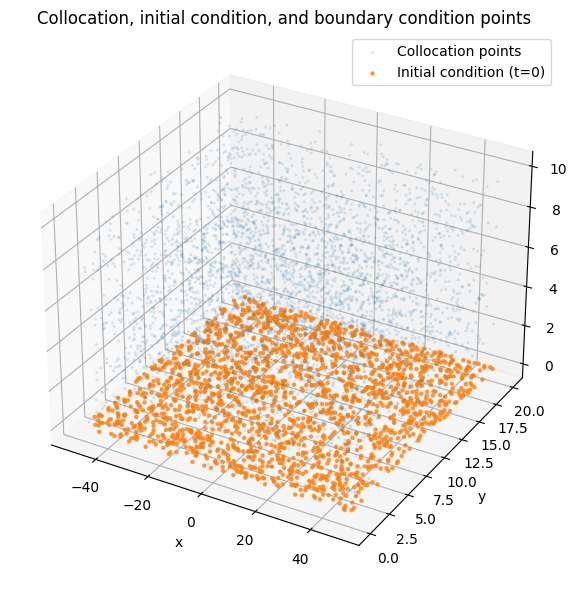

In [5]:
# --------------------------------------------------------------------
# 3D scatter plot: (x, y, t) domain with IC / BC / collocation
# --------------------------------------------------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Collocation points in the interior
ax.scatter(X_f_np[:, 0], X_f_np[:, 1], X_f_np[:, 2],
           s=2, alpha=0.1, label="Collocation points")

# Initial condition at t = 0
ax.scatter(X_ic_np[:, 0], X_ic_np[:, 1], X_ic_np[:, 2],
           s=5, alpha=0.7, label="Initial condition (t=0)")

# # Neumann boundary (x = x_min or x_max)
# ax.scatter(X_nbc_np[:, 0], X_nbc_np[:, 1], X_nbc_np[:, 2],
#            s=5, alpha=0.7, label="Neumann BC (x = ±50)")

# # Periodic boundary (y = y_min and y = y_max)
# ax.scatter(X_b0_np[:, 0], X_b0_np[:, 1], X_b0_np[:, 2],
#            s=5, alpha=0.7, label="Periodic BC (y = y_min)")
# ax.scatter(X_b1_np[:, 0], X_b1_np[:, 1], X_b1_np[:, 2],
#            s=5, alpha=0.7, label="Periodic BC (y = y_max)")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("t")
ax.set_title("Collocation, initial condition, and boundary condition points")

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()



In [ ]:
# Define a Physics-Informed Neural Network (PINN) as a fully-connected feedforward network
class PINN(nn.Module):
    def __init__(self, layers):
        """
        PINN constructor.

        Args:
            layers (list of int):
                Architecture specification. Example: [3, 100, 100, 100, 100, 1]
                - layers[0] : input dimension (e.g., x, y, t → 3)
                - layers[-1]: output dimension (e.g., scalar field u(x,y,t) → 1)
                - intermediate entries: number of neurons in each hidden layer.
        """
        super().__init__()

        # Use a ModuleList to store each Linear layer explicitly.
        # This gives us flexibility to iterate and apply activations manually in forward().
        self.layers = nn.ModuleList()

        # Create a sequence of Linear layers according to the 'layers' list.
        # For example, [3, 100, 100, 1] creates:
        #   Linear(3 → 100), Linear(100 → 100), Linear(100 → 1)
        for i in range(len(layers) - 1):
            in_dim = layers[i]
            out_dim = layers[i + 1]
            self.layers.append(nn.Linear(in_dim, out_dim))

        # Define the activation function to be used between hidden layers.
        # Here we use tanh, which is common in PINNs due to its smoothness and
        # ability to represent complex functions.
        self.activation = torch.tanh

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): input tensor of shape (N, layers[0]),
                              where each row is one point (e.g., [x, y, t]).

        Returns:
            torch.Tensor: output tensor of shape (N, layers[-1]),
                          representing the predicted solution u(x,y,t).
        """
        # Apply all but the last layer with activation.
        # Hidden layers: Linear -> tanh
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)      # Linear transformation
            x = self.activation(x)     # Nonlinear activation

        # The final layer is applied without activation (linear output).
        # This is standard for regression problems where the output can be any real value.
        x = self.layers[-1](x)
        return x


def gradients(u, x, order=1):
    """
    Compute the n-th order derivative of u with respect to x using autograd.

    Args:
        u (torch.Tensor):
            Tensor representing the function values u(x).
            Shape is typically (N, 1).
        x (torch.Tensor):
            Input tensor with requires_grad=True.
            Shape is (N, D), where D is the input dimension (e.g., 3 for x,y,t).
        order (int):
            Order of the derivative (1 for first derivative, 2 for second, etc.).

    Returns:
        torch.Tensor:
            The n-th order derivative of u with respect to x.
            Each call to autograd.grad returns the gradient of u w.r.t. x, so
            we apply it 'order' times in a loop to get higher-order derivatives.
    """
    for _ in range(order):
        # torch.autograd.grad computes the gradient of 'u' w.r.t. 'x'.
        # - grad_outputs=torch.ones_like(u) treats the gradient seed as all ones
        #   (i.e., d/dx sum(u) ).
        # - create_graph=True keeps the computation graph so we can differentiate again,
        #   which is necessary for higher-order derivatives.
        # - retain_graph=True prevents the graph from being freed, enabling multiple
        #   gradient computations on the same graph (useful if we call gradients()
        #   multiple times before a backward()).
        grads = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]

        # Update u to be its derivative so that next iteration differentiates again.
        u = grads

    # After 'order' iterations, 'u' holds the n-th derivative.
    return u


# -------------------------------------------------------------------
# Instantiate the PINN model
# -------------------------------------------------------------------

# Architecture: [3 input features, four hidden layers of 100, 1 output]
# - Input dim = 3 (x, y, t)
# - 4 hidden layers with 100 neurons each
# - Output dim = 1 (e.g., scalar field u(x,y,t))
model = PINN([3, 100, 100, 100, 100, 1]).to(device)

# Adam optimizer for training the PINN parameters
# - model.parameters(): all trainable weights and biases of the network
# - lr=1e-3: initial learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# -------------------------------------------------------------------
# Generate training data for the PINN:
#   - Collocation points for the PDE residual
#   - Initial condition points
#   - Neumann boundary condition points
#   - Periodic boundary condition points
# -------------------------------------------------------------------

# X_f: collocation points in the space-time domain (x, y, t)
#      used to enforce the PDE residual f(x,y,t) = 0.
X_f = generate_collocation_points(N_colloc)

# X_ic: points on the initial time slice (t = 0)
# u_ic: corresponding initial condition values u(x,y,0) at those points
X_ic, u_ic = generate_initial_points(N_ic)

# X_nbc: points on the Neumann boundary (e.g., x = x_min or x_max)
#        used to enforce derivative-based BCs like ∂u/∂n = 0.
X_nbc = generate_neumann_bc_points(N_bc)

# X_b0, X_b1: paired points on periodic boundaries (e.g., y = y_min and y = y_max)
#             used to enforce periodic BCs: u(x,y_min,t) = u(x,y_max,t) (and possibly
#             equality of derivatives as well).
X_b0, X_b1 = generate_periodic_bc_points(N_bc)


In [ ]:
# ---------------------------------------------
# Training with Adam Optimizer (first stage)
# ---------------------------------------------
def train(epochs):
    """
    Train the PINN using the Adam optimizer for a given number of epochs.

    The loss has four components:
      - f_loss: PDE residual (enforcing u_t = u_xx + u_yy)
      - ic_loss: initial condition at t = 0
      - nbc_loss: Neumann boundary condition on x = x_min/x_max
      - bc_loss: periodic boundary condition in y (y_min ↔ y_max)
    """
    for epoch in range(epochs):
        # Clear any previously accumulated gradients
        optimizer.zero_grad()

        # ---------------------------------------------------------
        # 1) PDE residual loss: enforce u_t - u_xx - u_yy = 0 in Ω
        # ---------------------------------------------------------

        # Enable gradient tracking w.r.t. X_f so that we can compute
        # derivatives of u(x,y,t) with respect to x, y, and t via autograd.
        X_f.requires_grad_(True)

        # Forward pass: u_f = u(x_f, y_f, t_f) at collocation points
        u_f = model(X_f)  # shape: (N_f, 1)

        # Compute first derivatives and second derivatives via helper `gradients`
        # X_f is assumed to be ordered as [x, y, t] per sample (dim=3):
        #   - column 0: x
        #   - column 1: y
        #   - column 2: t

        # u_t: time derivative ∂u/∂t
        # gradients(u_f, X_f) returns a tensor of shape (N_f, 3) containing
        # [∂u/∂x, ∂u/∂y, ∂u/∂t] for each point. We slice [:, 2:3] to get ∂u/∂t.
        u_t = gradients(u_f, X_f)[:, 2:3]

        # u_xx: second spatial derivative in x-direction, ∂²u/∂x²
        # First compute u_x = ∂u/∂x by slicing [:, 0:1], then differentiate again.
        u_x = gradients(u_f, X_f)[:, 0:1]
        u_xx = gradients(u_x, X_f)[:, 0:1]

        # u_yy: second spatial derivative in y-direction, ∂²u/∂y²
        # Similarly, first compute u_y = ∂u/∂y (slice [:, 1:2]), then differentiate.
        u_y = gradients(u_f, X_f)[:, 1:2]
        u_yy = gradients(u_y, X_f)[:, 1:2]

        # PDE residual for the 2D heat equation:
        #   u_t - u_xx - u_yy = 0
        # We enforce this by minimizing the mean squared residual.
        f_loss = torch.mean((u_t - u_xx - u_yy) ** 2)

        # ---------------------------------------------------------
        # 2) Initial condition loss: enforce u(x,y,0) = u_ic(x,y)
        # ---------------------------------------------------------

        # Forward pass on initial condition points (t=0 plane)
        u_ic_pred = model(X_ic)  # predicted u at IC points

        # L2 loss between predicted and prescribed initial condition values
        ic_loss = torch.mean((u_ic_pred - u_ic) ** 2)

        # ---------------------------------------------------------
        # 3) Neumann boundary loss: enforce ∂u/∂x = 0 at x = x_min/x_max
        # ---------------------------------------------------------

        # We need gradients w.r.t. X_nbc to compute ∂u/∂x on Neumann boundaries.
        X_nbc.requires_grad_(True)

        # Evaluate u on Neumann boundary points
        u_nbc = model(X_nbc)

        # du_dx: ∂u/∂x at Neumann boundary points
        du_dx = gradients(u_nbc, X_nbc)[:, 0:1]

        # Neumann BC: ∂u/∂x = 0  → penalty is (du_dx)^2
        nbc_loss = torch.mean(du_dx ** 2)

        # ---------------------------------------------------------
        # 4) Periodic boundary loss in y: u(x,y_min,t) = u(x,y_max,t)
        # ---------------------------------------------------------

        # Evaluate u at the two periodic boundaries in y (y=y_min and y=y_max),
        # for the same (x,t) pairs.
        u_b0 = model(X_b0)  # u(x, y_min, t)
        u_b1 = model(X_b1)  # u(x, y_max, t)

        # Periodic BC: enforce equality of values at two boundaries
        bc_loss = torch.mean((u_b0 - u_b1) ** 2)

        # ---------------------------------------------------------
        # 5) Total loss and optimization step
        # ---------------------------------------------------------

        # Total loss: PDE + weighted IC + Neumann BC + periodic BC.
        # The IC term is given a higher weight (100) to ensure the initial
        # profile is strongly enforced.
        loss = f_loss + 100 * ic_loss + nbc_loss + bc_loss

        # Backpropagate the total loss to compute gradients for all model params
        loss.backward()

        # Perform one Adam optimization step
        optimizer.step()

        # Monitor training progress every 500 epochs
        if epoch % 500 == 0:
            print(
                f"Epoch {epoch:5d} | Total Loss: {loss.item():.2e} | "
                f"PDE: {f_loss.item():.2e} | IC: {ic_loss.item():.2e}"
            )


# -------------------------------------------------------------
# Switch to L-BFGS Optimizer for Final Refinement (second stage)
# -------------------------------------------------------------

def compute_loss_and_backprop():
    """
    Compute the full PINN loss (PDE + IC + Neumann BC + periodic BC)
    and return the scalar loss.

    This function is written without calling `optimizer.zero_grad()` or
    `.backward()` inside, so that it can be used both:
      - inside a closure for L-BFGS,
      - or outside if needed.

    NOTE: In the L-BFGS closure below, we will explicitly call
          `lbfgs.zero_grad()` and then:
              loss = compute_loss_and_backprop()
              loss.backward()
    """

    # We need gradients w.r.t. X_f and X_nbc for the PDE and Neumann terms.
    X_f.requires_grad_(True)
    X_nbc.requires_grad_(True)

    # ---------- PDE residual term ----------
    u_f = model(X_f)
    u_t = gradients(u_f, X_f)[:, 2:3]
    u_x = gradients(u_f, X_f)[:, 0:1]
    u_xx = gradients(u_x, X_f)[:, 0:1]
    u_y = gradients(u_f, X_f)[:, 1:2]
    u_yy = gradients(u_y, X_f)[:, 1:2]
    f_loss = torch.mean((u_t - u_xx - u_yy) ** 2)

    # ---------- Initial condition term ----------
    u_ic_pred = model(X_ic)
    ic_loss = torch.mean((u_ic_pred - u_ic) ** 2)

    # ---------- Neumann boundary term ----------
    u_nbc = model(X_nbc)
    du_dx = gradients(u_nbc, X_nbc)[:, 0:1]
    nbc_loss = torch.mean(du_dx ** 2)

    # ---------- Periodic boundary term ----------
    u_b0 = model(X_b0)
    u_b1 = model(X_b1)
    bc_loss = torch.mean((u_b0 - u_b1) ** 2)

    # Weighted total loss (same structure as in Adam training)
    return f_loss + 100 * ic_loss + nbc_loss + bc_loss


print("Switching to L-BFGS for fine-tuning...")

# L-BFGS optimizer configuration:
# - lr: step size (often set to 1.0 for L-BFGS in PyTorch)
# - max_iter: maximum number of iterations
# - tolerance_grad: stopping tolerance for gradient norm
# - tolerance_change: stopping tolerance for function/parameter change
# - history_size: number of correction pairs to store for L-BFGS
lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50000,
    tolerance_grad=1e-10,
    tolerance_change=1e-12,
    history_size=50,
)

def closure():
    """
    Closure function required by PyTorch's LBFGS optimizer.

    L-BFGS in PyTorch is a "line-search" method that repeatedly:
      - calls this closure to recompute the loss and gradients,
      - performs internal updates until convergence or max_iter.

    Inside the closure, we must:
      1) Zero out gradients,
      2) Recompute the loss,
      3) Call loss.backward() to compute gradients,
      4) Return the loss (a scalar tensor).
    """
    # Clear gradients accumulated in previous closure calls
    lbfgs.zero_grad()

    # Compute total loss
    loss = compute_loss_and_backprop()

    # Backpropagate to compute gradients
    loss.backward()

    return loss

# Run L-BFGS optimization using the closure defined above.
# This will refine the parameters starting from the Adam-trained weights.
lbfgs.step(closure)

# Optionally save the refined model
# torch.save(model.state_dict(), "pinn_heat2d_refined.pt")
# print("L-BFGS fine-tuning complete. Final model saved.")


# -------------------------------------------------------------
# Generate a dense prediction grid for the trained PINN solution
# -------------------------------------------------------------

# Create 1D arrays for x, y, t over the domain
x = np.linspace(x_min, x_max, 101)   # Nx = 101 points in x ∈ [x_min, x_max]
y = np.linspace(y_min, y_max, 41)    # Ny = 41 points in y ∈ [y_min, y_max]
t = np.linspace(t_min, t_max, 200)   # Nt = 200 points in t ∈ [t_min, t_max]

# Generate a 3D meshgrid (X, Y, T) with indexing='ij' so that:
#   X.shape = (Nx, Ny, Nt)
#   Y.shape = (Nx, Ny, Nt)
#   T.shape = (Nx, Ny, Nt)
# where the first axis corresponds to x, second to y, third to t
X, Y, T = np.meshgrid(x, y, t, indexing='ij')

# Flatten the grid into a list of 3D points: (Nx*Ny*Nt, 3)
# Each row is [x_i, y_i, t_i].
grid = torch.tensor(
    np.stack([X.ravel(), Y.ravel(), T.ravel()], axis=1),
    dtype=torch.float32
).to(device)

# Evaluate the trained PINN on the full grid without tracking gradients
with torch.no_grad():
    # model(grid) returns shape (Nx*Ny*Nt, 1), so we reshape to (Nx, Ny, Nt)
    u_pred = model(grid).cpu().numpy().reshape(101, 41, 200)

# Save the PINN solution for later comparison/visualization
np.save("u_pinn.npy", u_pred)


# ------------------- FDM REFERENCE -------------------
# Finite Difference Method (FDM) solution of the same 2D heat equation
# used as a reference to compare with the PINN solution.
import numpy as np

# Domain size and discretization parameters
Lx, Ly, T = 100, 20, 10          # physical extents in x, y and final time
Nx, Ny, Nt = 101, 41, 200        # number of grid points in x, y, t

# Spatial and temporal grids
x = np.linspace(-50, 50, Nx)     # x ∈ [-50, 50]
y = np.linspace(0, 20, Ny)       # y ∈ [0, 20]
t = np.linspace(0, T, Nt)        # t ∈ [0, 10]

# Grid spacings
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]

# 2D grid for x and y (no time dimension here)
X, Y = np.meshgrid(x, y, indexing='ij')

# Initialize the solution array: u(x, y, t)
# Shape: (Nx, Ny, Nt)
u = np.zeros((Nx, Ny, Nt))

# Initial condition at t = 0: top-hat profile in x:
#   u(x, y, 0) = 1 if |x| <= 5, else 0 (for all y)
u[:, :, 0] = np.where(np.abs(X) <= 5, 1.0, 0.0)

# Diffusion coefficient alpha for the heat equation
alpha = 1

# Dimensionless diffusion numbers in x and y directions
# For an explicit scheme, stability often requires:
#   rx + ry <= 0.5 (roughly, depending on the scheme)
rx = alpha * dt / dx**2
ry = alpha * dt / dy**2

# Explicit time-stepping loop for the 2D heat equation
#   u_t = alpha (u_xx + u_yy)
for n in range(Nt - 1):
    # Copy current time slice (n) into a temporary array
    u_next = u[:, :, n].copy()

    # Loop over interior x-points (i = 1 ... Nx-2)
    for i in range(1, Nx - 1):
        # Loop over all y indices (j = 0 ... Ny-1)
        for j in range(Ny):
            # Periodic index in y-direction:
            #   jp: j+1 with wrap-around
            #   jm: j-1 with wrap-around
            jp = (j + 1) % Ny
            jm = (j - 1) % Ny

            # Discrete 2D heat equation update:
            # u^{n+1}_{i,j} = u^{n}_{i,j}
            #   + rx * (u_{i+1,j}^n - 2 u_{i,j}^n + u_{i-1,j}^n)
            #   + ry * (u_{i,j+1}^n - 2 u_{i,j}^n + u_{i,j-1}^n)
            u_next[i, j] = (
                u[i, j, n]
                + rx * (u[i + 1, j, n] - 2 * u[i, j, n] + u[i - 1, j, n])
                + ry * (u[i, jp, n] - 2 * u[i, j, n] + u[i, jm, n])
            )

    # Neumann boundary conditions in x:
    #   ∂u/∂x = 0 at x = x_min and x = x_max
    # A simple way is to mirror the adjacent interior values:
    #   u[0, :]   = u[1, :]
    #   u[-1, :]  = u[-2, :]
    u_next[0, :] = u_next[1, :]
    u_next[-1, :] = u_next[-2, :]

    # Store updated solution for the next time step
    u[:, :, n + 1] = u_next

# Save the FDM solution for comparison
np.save("u_fdm.npy", u)


# -------------------------------------------------------------
# Visualization: Compare FDM vs PINN in different slices
# -------------------------------------------------------------
from matplotlib import cm
import matplotlib.pyplot as plt

# Load solutions from disk
u_fdm = np.load("u_fdm.npy")      # shape: (Nx, Ny, Nt)
u_pinn = np.load("u_pinn.npy")    # shape: (Nx, Ny, Nt)

# Reconstruct grid vectors (must match the saved solutions)
Nx, Ny, Nt = u_fdm.shape
x = np.linspace(-50, 50, Nx)
y = np.linspace(0, 20, Ny)
t = np.linspace(0, 10, Nt)

# Indices for particular slices to visualize
ti = Nt // 2       # time index around the midpoint → t ≈ T/2
x_idx = Nx // 2    # index corresponding to x ≈ 0
y_idx = Ny // 2    # index corresponding to y ≈ midpoint

# Create meshgrids for 2D contour plotting
X, Y = np.meshgrid(x, y, indexing='ij')      # for x-y slices
X_xt, T_xt = np.meshgrid(x, t, indexing='ij')  # for x-t slices at fixed y
Y_yt, T_yt = np.meshgrid(y, t, indexing='ij')  # for y-t slices at fixed x

# ---------- 1) x-y slice at fixed t ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# FDM solution at time index ti
cf1 = axs[0].contourf(X, Y, u_fdm[:, :, ti], levels=20, cmap=cm.viridis)
axs[0].set_title(f"FDM (x-y at t ≈ {t[ti]:.2f})")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(cf1, ax=axs[0])

# PINN solution at the same time index ti
cf2 = axs[1].contourf(X, Y, u_pinn[:, :, ti], levels=20, cmap=cm.viridis)
axs[1].set_title(f"PINN (x-y at t ≈ {t[ti]:.2f})")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(cf2, ax=axs[1])

plt.tight_layout()
plt.savefig("fdm_vs_pinn_xy_t.png")
plt.show()

# ---------- 2) x-t slice at fixed y ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# FDM: take all x, all t at fixed y index y_idx → u_fdm[:, y_idx, :]
cf1 = axs[0].contourf(X_xt, T_xt, u_fdm[:, y_idx, :], levels=20, cmap=cm.viridis)
axs[0].set_title(f"FDM (x-t at y ≈ {y[y_idx]:.2f})")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(cf1, ax=axs[0])

# PINN: same slice for comparison
cf2 = axs[1].contourf(X_xt, T_xt, u_pinn[:, y_idx, :], levels=20, cmap=cm.viridis)
axs[1].set_title(f"PINN (x-t at y ≈ {y[y_idx]:.2f})")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(cf2, ax=axs[1])

plt.tight_layout()
plt.savefig("fdm_vs_pinn_xt_yfixed.png")
plt.show()

# ---------- 3) y-t slice at fixed x ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# FDM: take all y, all t at fixed x index x_idx → u_fdm[x_idx, :, :]
cf1 = axs[0].contourf(Y_yt, T_yt, u_fdm[x_idx, :, :], levels=20, cmap=cm.viridis)
axs[0].set_title(f"FDM (y-t at x ≈ {x[x_idx]:.2f})")
axs[0].set_xlabel("y")
axs[0].set_ylabel("t")
plt.colorbar(cf1, ax=axs[0])

# PINN: same y-t slice at x ≈ 0
cf2 = axs[1].contourf(Y_yt, T_yt, u_pinn[x_idx, :, :], levels=20, cmap=cm.viridis)
axs[1].set_title(f"PINN (y-t at x ≈ {x[x_idx]:.2f})")
axs[1].set_xlabel("y")
axs[1].set_ylabel("t")
plt.colorbar(cf2, ax=axs[1])

plt.tight_layout()
plt.savefig("fdm_vs_pinn_yt_xfixed.png")
plt.show()


In [ ]:
# -------------------------------------------------------------
# Generate a dense space-time grid and evaluate the PINN solution
# -------------------------------------------------------------

# Create 1D coordinate arrays (grid points) in each dimension:
#   - x: 101 points from x_min to x_max
#   - y: 41 points from y_min to y_max
#   - t: 200 points from t_min to t_max
x = np.linspace(x_min, x_max, 101)
y = np.linspace(y_min, y_max, 41)
t = np.linspace(t_min, t_max, 200)

# Create a 3D meshgrid for (x, y, t) using 'ij' indexing:
#   X[i,j,k] = x[i]
#   Y[i,j,k] = y[j]
#   T[i,j,k] = t[k]
# Shapes: X, Y, T ∈ R^{101 × 41 × 200}
X, Y, T = np.meshgrid(x, y, t, indexing='ij')

# Flatten the 3D grid into a list of points:
#   - X.ravel(), Y.ravel(), T.ravel() → 1D arrays of length 101*41*200
#   - np.stack(..., axis=1) → (N_points, 3), where each row is [x_i, y_i, t_i]
grid = torch.tensor(
    np.stack([X.ravel(), Y.ravel(), T.ravel()], axis=1),
    dtype=torch.float32
).to(device)

# Disable gradient tracking (we are only doing prediction / evaluation here)
with torch.no_grad():
    # Evaluate the trained PINN on all grid points.
    # model(grid) has shape (N_points, 1); we reshape it back to (101, 41, 200)
    # to match the (x, y, t) meshgrid structure.
    u_pred = model(grid).cpu().numpy().reshape(101, 41, 200)

# Save the predicted PINN solution to disk for later analysis/plotting
np.save("u_pinn.npy", u_pred)


# ------------------- FDM REFERENCE -------------------
# Compute a reference solution using a Finite Difference Method (FDM)
# for the same 2D heat equation and compare with the PINN.
import numpy as np

# Physical domain sizes and final time
Lx, Ly, T = 100, 20, 10

# Number of grid points in x, y, and t for the FDM discretization
Nx, Ny, Nt = 101, 41, 200

# Uniform spatial and temporal grids
x = np.linspace(-50, 50, Nx)  # x ∈ [-50, 50], length Nx
y = np.linspace(0, 20, Ny)    # y ∈ [0, 20], length Ny
t = np.linspace(0, T, Nt)     # t ∈ [0, 10], length Nt

# Grid spacings
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]

# 2D spatial grid for initial condition and Laplacian stencils
X, Y = np.meshgrid(x, y, indexing='ij')

# Initialize solution array u(x,y,t):
#   shape (Nx, Ny, Nt), where:
#     u[i, j, n] ≈ u(x_i, y_j, t_n)
u = np.zeros((Nx, Ny, Nt))

# Initial condition at t=0: top-hat in x:
#   u(x,y,0) = 1 if |x| ≤ 5, else 0 (for all y)
u[:, :, 0] = np.where(np.abs(X) <= 5, 1.0, 0.0)

# Diffusion coefficient and dimensionless diffusion numbers
alpha = 1
rx = alpha * dt / dx**2  # diffusion number in x
ry = alpha * dt / dy**2  # diffusion number in y

# Explicit time-stepping loop for the 2D heat equation:
#   u_t = α (u_xx + u_yy)
for n in range(Nt - 1):
    # Copy the current time slice (at t_n). This will be updated to form u at t_{n+1}.
    u_next = u[:, :, n].copy()

    # Loop over interior x-nodes (excluding boundaries at i=0 and i=Nx-1)
    for i in range(1, Nx - 1):
        # Loop over all y-nodes; periodic in y-direction
        for j in range(Ny):
            # Periodic indices in y:
            #   jp = j+1 wrapped around to 0 at Ny
            #   jm = j-1 wrapped around to Ny-1 at -1
            jp = (j + 1) % Ny
            jm = (j - 1) % Ny

            # Discrete explicit update:
            #   u^{n+1}_{i,j} = u^{n}_{i,j}
            #     + rx (u^{n}_{i+1,j} - 2 u^{n}_{i,j} + u^{n}_{i-1,j})
            #     + ry (u^{n}_{i,jp} - 2 u^{n}_{i,j} + u^{n}_{i,jm})
            u_next[i, j] = (
                u[i, j, n]
                + rx * (u[i + 1, j, n] - 2 * u[i, j, n] + u[i - 1, j, n])
                + ry * (u[i, jp, n] - 2 * u[i, j, n] + u[i, jm, n])
            )

    # Neumann BC in x-direction: ∂u/∂x = 0 at x_min and x_max.
    # Implemented by mirroring the adjacent interior values:
    #   u[0, :]   = u[1, :]
    #   u[-1, :]  = u[-2, :]
    u_next[0, :] = u_next[1, :]
    u_next[-1, :] = u_next[-2, :]

    # Store the updated field as the solution at time index n+1
    u[:, :, n + 1] = u_next

# Save the FDM reference solution
np.save("u_fdm.npy", u)


from matplotlib import cm
import matplotlib.pyplot as plt

# ------------------- BASE COMPARISON PLOTS -------------------

# Load the previously saved FDM and PINN solutions from disk
u_fdm = np.load("u_fdm.npy")      # FDM solution: shape (Nx, Ny, Nt)
u_pinn = np.load("u_pinn.npy")    # PINN solution: same shape

# Infer grid sizes from the loaded FDM solution
Nx, Ny, Nt = u_fdm.shape

# Reconstruct grid vectors (must be consistent with what was used above)
x = np.linspace(-50, 50, Nx)
y = np.linspace(0, 20, Ny)
t = np.linspace(0, 10, Nt)

# Choose slice indices for visualization:
ti = Nt // 2       # time index near mid-time (t ≈ T/2)
x_idx = Nx // 2    # index corresponding to x ≈ 0
y_idx = Ny // 2    # index corresponding to y ≈ mid-height

# Create meshgrids for 2D contour plots:
#   - X,Y for x-y slices
#   - X_xt,T_xt for x-t slices at fixed y
#   - Y_yt,T_yt for y-t slices at fixed x
X, Y = np.meshgrid(x, y, indexing='ij')
X_xt, T_xt = np.meshgrid(x, t, indexing='ij')
Y_yt, T_yt = np.meshgrid(y, t, indexing='ij')

# ---------- x-y slice at fixed t ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# FDM: u(x,y,t≈mid) as a contour in x-y plane
cf1 = axs[0].contourf(X, Y, u_fdm[:, :, ti], levels=20, cmap=cm.viridis)
axs[0].set_title(f"FDM (x-y at t ≈ {t[ti]:.2f})")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(cf1, ax=axs[0])

# PINN: same x-y slice for comparison
cf2 = axs[1].contourf(X, Y, u_pinn[:, :, ti], levels=20, cmap=cm.viridis)
axs[1].set_title(f"PINN (x-y at t ≈ {t[ti]:.2f})")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(cf2, ax=axs[1])

plt.tight_layout()
plt.savefig("fdm_vs_pinn_xy_t.png")
plt.show()

# ---------- x-t slice at fixed y ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# FDM: slice through the domain at fixed y ≈ y[y_idx]
cf1 = axs[0].contourf(X_xt, T_xt, u_fdm[:, y_idx, :], levels=20, cmap=cm.viridis)
axs[0].set_title(f"FDM (x-t at y ≈ {y[y_idx]:.2f})")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(cf1, ax=axs[0])

# PINN: same x-t slice for comparison
cf2 = axs[1].contourf(X_xt, T_xt, u_pinn[:, y_idx, :], levels=20, cmap=cm.viridis)
axs[1].set_title(f"PINN (x-t at y ≈ {y[y_idx]:.2f})")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(cf2, ax=axs[1])

plt.tight_layout()
plt.savefig("fdm_vs_pinn_xt_yfixed.png")
plt.show()

# ---------- y-t slice at fixed x ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# FDM: slice through the domain at fixed x ≈ x[x_idx]
cf1 = axs[0].contourf(Y_yt, T_yt, u_fdm[x_idx, :, :], levels=20, cmap=cm.viridis)
axs[0].set_title(f"FDM (y-t at x ≈ {x[x_idx]:.2f})")
axs[0].set_xlabel("y")
axs[0].set_ylabel("t")
plt.colorbar(cf1, ax=axs[0])

# PINN: same y-t slice for comparison
cf2 = axs[1].contourf(Y_yt, T_yt, u_pinn[x_idx, :, :], levels=20, cmap=cm.viridis)
axs[1].set_title(f"PINN (y-t at x ≈ {x[x_idx]:.2f})")
axs[1].set_xlabel("y")
axs[1].set_ylabel("t")
plt.colorbar(cf2, ax=axs[1])

plt.tight_layout()
plt.savefig("fdm_vs_pinn_yt_xfixed.png")
plt.show()


# -------------------------------------------------------------
# Extended comparison: absolute error fields and line plots
# -------------------------------------------------------------

# Define x, y, t grids from the PINN solution shape (same as FDM)
Nx, Ny, Nt = u_pinn.shape
x = np.linspace(-50, 50, Nx)
y = np.linspace(0, 20, Ny)
t = np.linspace(0, 10, Nt)

# Meshgrids again for plotting with consistent shapes
X, Y = np.meshgrid(x, y, indexing='ij')
X_xt, T_xt = np.meshgrid(x, t, indexing='ij')
Y_yt, T_yt = np.meshgrid(y, t, indexing='ij')

# Slice indices (reuse the same definition)
ti = Nt // 2      # time midpoint index
x_idx = Nx // 2   # x ≈ 0
y_idx = Ny // 2   # y ≈ mid-height

# Absolute error at each grid point: |u_PINN - u_FDM|
error = np.abs(u_pinn - u_fdm)

# Global relative L2 error across the full space-time domain:
#   ||u_PINN - u_FDM||_2 / ||u_FDM||_2
rel_l2_error = np.linalg.norm(u_pinn - u_fdm) / np.linalg.norm(u_fdm)
print(f"Global Relative L2 Error: {rel_l2_error:.4e}")

# ---------- x-y slice with error ----------
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# FDM x-y slice
cf1 = axs[0].contourf(X, Y, u_fdm[:, :, ti], levels=20, cmap=cm.viridis)
axs[0].set_title(f"FDM (x-y at t ≈ {t[ti]:.2f})")
axs[0].set_xlabel("x"); axs[0].set_ylabel("y")
plt.colorbar(cf1, ax=axs[0])

# PINN x-y slice
cf2 = axs[1].contourf(X, Y, u_pinn[:, :, ti], levels=20, cmap=cm.viridis)
axs[1].set_title(f"PINN (x-y at t ≈ {t[ti]:.2f})")
axs[1].set_xlabel("x"); axs[1].set_ylabel("y")
plt.colorbar(cf2, ax=axs[1])

# Absolute error x-y slice
cf3 = axs[2].contourf(X, Y, error[:, :, ti], levels=20, cmap=cm.plasma)
axs[2].set_title("Absolute Error (x-y)")
axs[2].set_xlabel("x"); axs[2].set_ylabel("y")
plt.colorbar(cf3, ax=axs[2])

plt.tight_layout()
plt.savefig("fdm_vs_pinn_xy_with_error.png")
plt.show()

# ---------- x-t slice with error ----------
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# FDM x-t slice at fixed y
cf1 = axs[0].contourf(X_xt, T_xt, u_fdm[:, y_idx, :], levels=20, cmap=cm.viridis)
axs[0].set_title(f"FDM (x-t at y ≈ {y[y_idx]:.2f})")
axs[0].set_xlabel("x"); axs[0].set_ylabel("t")
plt.colorbar(cf1, ax=axs[0])

# PINN x-t slice
cf2 = axs[1].contourf(X_xt, T_xt, u_pinn[:, y_idx, :], levels=20, cmap=cm.viridis)
axs[1].set_title(f"PINN (x-t at y ≈ {y[y_idx]:.2f})")
axs[1].set_xlabel("x"); axs[1].set_ylabel("t")
plt.colorbar(cf2, ax=axs[1])

# Absolute error x-t slice
cf3 = axs[2].contourf(X_xt, T_xt, error[:, y_idx, :], levels=20, cmap=cm.plasma)
axs[2].set_title("Absolute Error (x-t)")
axs[2].set_xlabel("x"); axs[2].set_ylabel("t")
plt.colorbar(cf3, ax=axs[2])

plt.tight_layout()
plt.savefig("fdm_vs_pinn_xt_with_error.png")
plt.show()

# ---------- y-t slice with error ----------
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# FDM y-t slice at fixed x
cf1 = axs[0].contourf(Y_yt, T_yt, u_fdm[x_idx, :, :], levels=20, cmap=cm.viridis)
axs[0].set_title(f"FDM (y-t at x ≈ {x[x_idx]:.2f})")
axs[0].set_xlabel("y"); axs[0].set_ylabel("t")
plt.colorbar(cf1, ax=axs[0])

# PINN y-t slice
cf2 = axs[1].contourf(Y_yt, T_yt, u_pinn[x_idx, :, :], levels=20, cmap=cm.viridis)
axs[1].set_title(f"PINN (y-t at x ≈ {x[x_idx]:.2f})")
axs[1].set_xlabel("y"); axs[1].set_ylabel("t")
plt.colorbar(cf2, ax=axs[1])

# Absolute error y-t slice
cf3 = axs[2].contourf(Y_yt, T_yt, error[x_idx, :, :], levels=20, cmap=cm.plasma)
axs[2].set_title("Absolute Error (y-t)")
axs[2].set_xlabel("y"); axs[2].set_ylabel("t")
plt.colorbar(cf3, ax=axs[2])

plt.tight_layout()
plt.savefig("fdm_vs_pinn_yt_with_error.png")
plt.show()


# ------------------- LINE PLOTS -------------------
# 1D cuts to see detailed agreement and error along specific lines
# -------------------------------------------------

# Line 1: u vs y at fixed x, t (vertical line at x≈0, time≈mid)
uy_fdm = u_fdm[x_idx, :, ti]
uy_pinn = u_pinn[x_idx, :, ti]
uy_err = np.abs(uy_fdm - uy_pinn)

plt.figure(figsize=(8, 4))
plt.plot(y, uy_fdm, label="FDM", linewidth=2)
plt.plot(y, uy_pinn, '--', label="PINN", linewidth=2)
plt.plot(y, uy_err, ':', label="|Error|", linewidth=2)
plt.title(f"u vs y at x ≈ {x[x_idx]:.2f}, t ≈ {t[ti]:.2f}")
plt.xlabel("y")
plt.ylabel("u")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lineplot_u_vs_y.png")
plt.show()

# Line 2: u vs x at fixed y, t (horizontal line at y≈mid, time≈mid)
ux_fdm = u_fdm[:, y_idx, ti]
ux_pinn = u_pinn[:, y_idx, ti]
ux_err = np.abs(ux_fdm - ux_pinn)

plt.figure(figsize=(8, 4))
plt.plot(x, ux_fdm, label="FDM", linewidth=2)
plt.plot(x, ux_pinn, '--', label="PINN", linewidth=2)
plt.plot(x, ux_err, ':', label="|Error|", linewidth=2)
plt.title(f"u vs x at y ≈ {y[y_idx]:.2f}, t ≈ {t[ti]:.2f}")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lineplot_u_vs_x.png")
plt.show()

# Line 3: u vs t at fixed x, y (time evolution at a single point (x≈0, y≈mid))
ut_fdm = u_fdm[x_idx, y_idx, :]
ut_pinn = u_pinn[x_idx, y_idx, :]
ut_err = np.abs(ut_fdm - ut_pinn)

plt.figure(figsize=(8, 4))
plt.plot(t, ut_fdm, label="FDM", linewidth=2)
plt.plot(t, ut_pinn, '--', label="PINN", linewidth=2)
plt.plot(t, ut_err, ':', label="|Error|", linewidth=2)
plt.title(f"u vs t at x ≈ {x[x_idx]:.2f}, y ≈ {y[y_idx]:.2f}")
plt.xlabel("t")
plt.ylabel("u")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lineplot_u_vs_t.png")
plt.show()
